
## The goal of this Notebook is to classify 3 different types of images:  abstract, portraits and landscapes.  

  


In [1]:
#

## Model 1: Baseline Feedforward neural network classifier 

### Use the training images to train up a feedforward classifier using the provided training.txt file which has the image names and labels.  

### Use the validation images to assess the performance of the classifier using the associated image names and labels.

### Create a plot of the training and validation results as a function of the epoch.  If you are using different metrics, be sure to put them on different plots.

In [2]:
# !pip install torchvision


In [133]:
# imports go here
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import requests
import os
import pandas as pd
import warnings
warnings.filterwarnings('ignore')


In [134]:
# Path to the folder containing images and truth.txt
data_folder = "data"
truth_file = os.path.join(data_folder, "truth.txt")

df = pd.read_csv(truth_file, sep="\t") 

df.head()

,Filename,TrainValidateTest,Style,Genre,Artist
0,00000.jpg,train,landscape,Impressionism,Camille Pissarro
1,00001.jpg,train,landscape,Neo-Romanticism,Cookham
2,00002.jpg,train,landscape,Impressionism,Paul Gauguin
3,00003.jpg,train,landscape,Post-Impressionism,Gustave Loiseau
4,00004.jpg,train,landscape,Ink and wash painting,Xu Beihong


In [135]:
df.Style.value_counts()

Style
portrait         16841
landscape        15005
abstract          9498
self-portrait     1530
Name: count, dtype: int64

In [136]:
# for posterity, I put the images self-portrait and portait together
df.replace('self-portrait', 'portrait', inplace=True)
df.Style.value_counts()

Style
portrait     18371
landscape    15005
abstract      9498
Name: count, dtype: int64

In [7]:
# Function to check if the image file exists in the folder
def image_exists(row, data_folder):
    image_path = os.path.join(data_folder, row['TrainValidateTest'], row['Filename'])
    return os.path.exists(image_path)

print(f"Original Number of Images: {len(df)}")
# Filter out rows where the image file is missing
df = df[df.apply(lambda row: image_exists(row, data_folder), axis=1)]

# Verify that the missing images have been removed
print(f"Number of remaining images after removing missing images: {len(df)}")


Original Number of Images: 42874
Number of remaining images after removing missing images: 42873


In [137]:
# organize the data for training and validations
train_data = []
val_data = []

# Loop through the DataFrame and sort images into train/val/test sets
for index, row in df.iterrows():
    image_path = os.path.join(data_folder, row['TrainValidateTest'], row['Filename'])
    
    if row['TrainValidateTest'] == 'train':
        train_data.append((image_path, row['Style']))  # Append image path and label (Style)
        
    elif row['TrainValidateTest'] == 'validate':
        val_data.append((image_path, row['Style']))
        


In [138]:
train_data[0], val_data[0]

(('data/train/00000.jpg', 'landscape'),
 ('data/validate/32000.jpg', 'abstract'))

In [ ]:
#

**Upto this point, we have done a quick pre-processing of the data and have the train and validation in a tuple that has the path to the train image and a label to it. Next we move to building the ImageDataset class and the dataloaders** 

In [ ]:
#

In [11]:

# re-factored by chatGPT
# Custom Dataset class to load images and their labels
class ImageDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        # Map label to integer index 
        label_map = {'abstract': 0, 'portrait': 1, 'landscape': 2}
        label_idx = label_map[label]
        
        return image, label_idx

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),          # Convert image to PyTorch tensor
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization
])

# Create Dataset objects
train_dataset = ImageDataset(train_data, transform=transform)
val_dataset = ImageDataset(val_data, transform=transform)

# Create DataLoader objects for batching
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


**Next I create an architecture for the feedforward network. I use 5 different fully connected layers with varying number of hidden layers. For the activation function, I use a ReLU activation function after each fully connected layer**

In [12]:
import torch.nn as nn

# Deeper Feedforward Neural Network
class DeepFeedforwardNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, output_size):
        super(DeepFeedforwardNN, self).__init__()
        self.input_size = input_size
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.fc5 = nn.Linear(hidden_size4, output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = x.view(-1, input_size)  # Flatten the image tensor
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
#         x = self.dropout(x)  # Dropout after second layer
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.relu(x)
        x = self.fc5(x)
        return x

In [13]:
# training the model
# useful reference: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

def trainFeedforward(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()  # Zero out gradients
            
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train

        # Append training loss and accuracy for plotting
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        val_loss /= len(val_loader)
        val_acc = 100 * correct_val / total_val
        
        # Append validation loss and accuracy for plotting
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, '
              f'Train Acc: {train_acc:.2f}%, '
              f'Val Loss: {val_loss:.4f}, '
              f'Val Acc: {val_acc:.2f}%')


    return train_losses, val_losses, train_accuracies, val_accuracies

# Train the model and track metrics
# define the device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Parameters for the deep feedforward model
input_size = 224 * 224 * 3  # Flattened image size (for 224x224 RGB images)
hidden_size1 = 1024
hidden_size2 = 512
hidden_size3 = 256
hidden_size4 = 128
output_size = 3  # 3 classes: abstract, portraits, landscapes

# Instantiate the deeper model
model = DeepFeedforwardNN(input_size, hidden_size1, hidden_size2, \
                          hidden_size3, hidden_size4, output_size).to(device)


# Optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.005)

train_losses, val_losses, train_accuracies, val_accuracies = trainFeedforward(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=50, device=device
)


Using mps device
Epoch [1/50], Train Loss: 0.9234, Train Acc: 56.44%, Val Loss: 0.8313, Val Acc: 62.25%
Epoch [2/50], Train Loss: 0.7987, Train Acc: 63.84%, Val Loss: 0.8016, Val Acc: 64.03%
Epoch [3/50], Train Loss: 0.7581, Train Acc: 66.41%, Val Loss: 0.8023, Val Acc: 64.17%
Epoch [4/50], Train Loss: 0.7348, Train Acc: 67.72%, Val Loss: 0.7573, Val Acc: 66.60%
Epoch [5/50], Train Loss: 0.7168, Train Acc: 68.45%, Val Loss: 0.7440, Val Acc: 67.72%
Epoch [6/50], Train Loss: 0.7007, Train Acc: 69.56%, Val Loss: 0.7361, Val Acc: 68.40%
Epoch [7/50], Train Loss: 0.6870, Train Acc: 70.27%, Val Loss: 0.7277, Val Acc: 69.20%
Epoch [8/50], Train Loss: 0.6754, Train Acc: 71.12%, Val Loss: 0.8068, Val Acc: 65.35%
Epoch [9/50], Train Loss: 0.6656, Train Acc: 71.74%, Val Loss: 0.7844, Val Acc: 66.42%
Epoch [10/50], Train Loss: 0.6557, Train Acc: 72.07%, Val Loss: 0.7233, Val Acc: 68.83%
Epoch [11/50], Train Loss: 0.6436, Train Acc: 72.81%, Val Loss: 0.7256, Val Acc: 69.48%
Epoch [12/50], Train Los

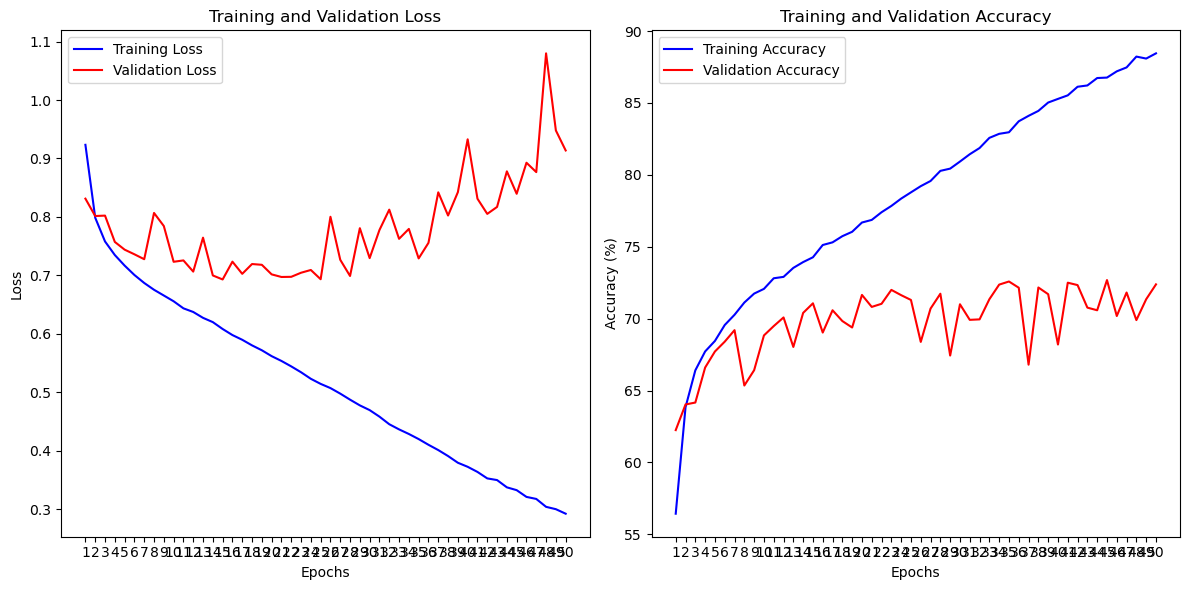

In [14]:
# Plot the training and validation losses
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    
    # Plot Loss
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Training Loss')
    plt.plot(epochs, val_losses, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(epochs)
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.xticks(epochs)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the results
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)


In [ ]:
#

### Some Observations about the FeedForward NN Results
The increasing gap between training and validation performance is a key indicator of overfitting. While the training accuracy continues to improve and the loss decreases, the validation metrics do not follow the same trend, leading to poor generalization.
The validation loss even increases towards the later epochs, which suggests that the model is memorizing the training data rather than learning generalizable features.

In [ ]:
#

## Approach 2 Baseline CNN classifier 

### Use the training images to train up a CNN classifier using the provided training.txt file which has the image names and labels.  

### Use the validation images to assess the performance of the classifier using the associated image names and labels.

### Create a plot of the training and validation results as a function of the epoch.


In [16]:
# Dataset class to load and preprocess images
class ImageDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        # Map label to integer index 
        label_map = {'abstract': 0, 'portrait': 1, 'landscape': 2}
        label_idx = label_map[label]
        
        return image, label_idx

# Define transforms for data augmentation and resizing
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

])

# apply the appropriate transforms
train_dataset = ImageDataset(train_data, transform=train_transform)
val_dataset = ImageDataset(val_data, transform=val_transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

In [119]:
import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn as nn

# Simple CNN for Image Classification with 3 Conv Blocks
class BaselineCNN(nn.Module):
    
    def __init__(self, num_classes=3): 
        super(BaselineCNN, self).__init__()
        
        # First convolutional block
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.maxPool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second convolutional block
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.maxPool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Third convolutional block (Additional Block)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3)
        self.maxPool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        # Adjusted size after convolution and pooling: 128 * 24 * 24
        self.fc1 = nn.Linear(128 * 24 * 24, 256)
        self.fc2 = nn.Linear(256, num_classes)
        
        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # First conv block
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.maxPool1(x)
        
        # Second conv block
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.maxPool2(x)
        
        # Third conv block
        x = self.relu(self.conv5(x))
        x = self.relu(self.conv6(x))
        x = self.maxPool3(x)
        
        # Flatten the output from the conv layers
        x = x.view(x.size(0), -1)  # Flatten the tensor
        
        # Fully connected layers
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

        

# Instantiate the model
model_cnn = BaselineCNN(num_classes=3).to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=0.005)


In [ ]:
# Training function for CNN
def train_cnn(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()  # Zero out gradients
            
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train

        # Append training loss and accuracy for plotting
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        val_loss /= len(val_loader)
        val_acc = 100 * correct_val / total_val
        
        # Append validation loss and accuracy for plotting
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        # Save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'bestBaseline_cnn_model.pth')

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, '
              f'Train Acc: {train_acc:.2f}%, '
              f'Val Loss: {val_loss:.4f}, '
              f'Val Acc: {val_acc:.2f}%')

    return train_losses, val_losses, train_accuracies, val_accuracies

# Train the model and track metrics
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

train_losses_cnn, val_losses_cnn, train_accuracies_cnn, val_accuracies_cnn = train_cnn(
    model_cnn, train_loader, val_loader, criterion, optimizer, num_epochs=15, device=device
)


Using mps device
Epoch [1/15], Train Loss: 0.9860, Train Acc: 61.42%, Val Loss: 0.9152, Val Acc: 62.83%
Epoch [2/15], Train Loss: 0.7509, Train Acc: 67.26%, Val Loss: 0.7262, Val Acc: 69.78%
Epoch [3/15], Train Loss: 0.6907, Train Acc: 70.41%, Val Loss: 0.7195, Val Acc: 68.77%
Epoch [4/15], Train Loss: 0.6719, Train Acc: 71.53%, Val Loss: 0.6978, Val Acc: 70.40%
Epoch [5/15], Train Loss: 0.6266, Train Acc: 73.35%, Val Loss: 0.6492, Val Acc: 72.73%
Epoch [6/15], Train Loss: 0.6019, Train Acc: 75.04%, Val Loss: 0.6933, Val Acc: 70.27%


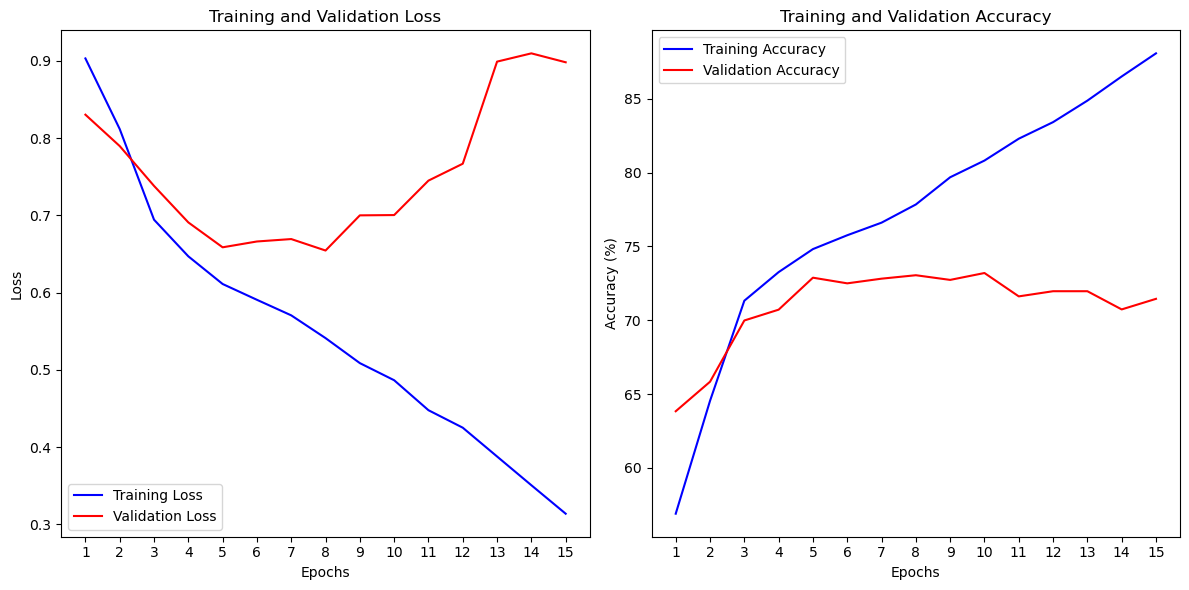

In [71]:
# plot the results
plot_metrics(train_losses_cnn, val_losses_cnn, train_accuracies_cnn, val_accuracies_cnn)


In [ ]:
#

### Some Observations from the Baseline CNN

The Baseline CNN verfits after epoch 5, as shown by widening gap between training and validation performance. Although the model learns the training data effectively, it struggles to generalize to the validation set, resulting in plateaued validation accuracy and fluctuating validation loss.

Perhaps it might be useful to:
1. **Increase Regularization**: Experiment with introducing dropout layers or adding L2 regularization to help prevent overfitting.
2. **Early Stopping**: Introduce early stopping to stop training once the validation performance stagnates, preventing overfitting in later epochs.
3. **Learning Rate Scheduling**: Use a learning rate scheduler to reduce the learning rate after validation performance plateaus to fine-tune the model further.




In [ ]:
#

## Approach 3  Improved CNN classifier

### Chose a single parameter with at least 3 different values and optimize over that parameter.  The parameter could be the number or size of the convolutional kernels, the number/size of the layers.  Report the performance as a function of epoch for each version and select the best. 

In [ ]:
#

#### My Main Parameter of choice is the number/size of the layers but I also vary the size of the filters for the deeper layers. 

I plan to experiment with:

2 Convolutional Blocks (Shallow model)

3 Convolutional Blocks (Baseline model, as provided)

4 Convolutional Blocks (Deeper model)

5 Convolution Blocks (More Deeper model)

For each configuration, I track the validation accuracy over multiple epochs and compare the results to select the best-performing model.



In [17]:
# code optimized and re-written by chatGPT

class VariableDepthCNN(nn.Module):
    def __init__(self, num_blocks=3, num_classes=3):
        super(VariableDepthCNN, self).__init__()
        
        self.layers = nn.ModuleList()  # Store convolutional blocks
        
        # First convolutional block (fixed since input has 3 channels)
        in_channels = 3
        num_filters = 32
        
        # Add convolutional blocks based on num_blocks
        for i in range(num_blocks):
            self.layers.append(nn.Conv2d(in_channels=in_channels, out_channels=num_filters, kernel_size=3))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Conv2d(in_channels=num_filters, out_channels=num_filters, kernel_size=3))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.MaxPool2d(kernel_size=2, stride=2))  # Max Pooling
            
            in_channels = num_filters  # Update in_channels for the next block
            num_filters *= 2  # Double the number of filters for deeper layers
        
        # Add another MaxPooling layer to reduce spatial dimensions
        self.extra_pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max Pooling here as well
        
        # Dynamically calculate the input size for the first fully connected layer (fc1)
        self.flatten_input_size = self._get_conv_output_size((3, 224, 224))  # Assuming input image size is (3, 224, 224)
        
        # Fully connected layers
        self.fc1 = nn.Linear(self.flatten_input_size, 256)
        self.fc2 = nn.Linear(256, num_classes)
        
    def forward(self, x):
        # Pass through convolutional blocks
        for layer in self.layers:
            x = layer(x)
        
        # Additional max pooling layer to reduce the size further
        x = self.extra_pool(x)
        
        # Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x
    
    # Helper function to calculate the correct output size dynamically
    def _get_conv_output_size(self, shape):
        # Create a dummy input tensor with the shape (batch_size=1, channels, height, width)
        with torch.no_grad():
            x = torch.rand(1, *shape)
            # Pass through the convolutional layers
            for layer in self.layers:
                x = layer(x)
            # Pass through the extra pooling layer
            x = self.extra_pool(x)
            # Flatten and return the size of the output
            return x.view(1, -1).size(1)


In [11]:
# Function to print the model summary and ensure input data is on the correct device
from torchsummary import summary

def print_model_summary(num_blocks):
    device = torch.device("cpu")  # Use CPU explicitly
    model = VariableDepthCNN(num_blocks=num_blocks).to(device)  # Move the model to CPU
    
    print(f"Model Summary for {num_blocks} Convolutional Blocks:")
    summary(model, input_size=(3, 224, 224), device='cpu')

# Example usage for printing the model summary on CPU
depth_values = [2, 4, 5]

for depth in depth_values:
    print_model_summary(depth)


Model Summary for 2 Convolutional Blocks:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 222, 222]             896
              ReLU-2         [-1, 32, 222, 222]               0
            Conv2d-3         [-1, 32, 220, 220]           9,248
              ReLU-4         [-1, 32, 220, 220]               0
         MaxPool2d-5         [-1, 32, 110, 110]               0
            Conv2d-6         [-1, 64, 108, 108]          18,496
              ReLU-7         [-1, 64, 108, 108]               0
            Conv2d-8         [-1, 64, 106, 106]          36,928
              ReLU-9         [-1, 64, 106, 106]               0
        MaxPool2d-10           [-1, 64, 53, 53]               0
        MaxPool2d-11           [-1, 64, 26, 26]               0
           Linear-12                  [-1, 256]      11,075,840
           Linear-13                    [-1, 3]             7

In [44]:
# Training function for CNN
def train_cnn(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()  # Zero out gradients
            
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train

        # Append training loss and accuracy for plotting
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        val_loss /= len(val_loader)
        val_acc = 100 * correct_val / total_val
        
        # Append validation loss and accuracy for plotting
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        # Save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'bestfinetune_cnn_model.pth')

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, '
              f'Train Acc: {train_acc:.2f}%, '
              f'Val Loss: {val_loss:.4f}, '
              f'Val Acc: {val_acc:.2f}%')

    return train_losses, val_losses, train_accuracies, val_accuracies

# Train the model and track metrics
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [19]:
import torch

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using {device} device")

# Function to train models with different depths and track performance
def train_model_with_depth(num_blocks, train_loader, val_loader, num_epochs=15):
    # Initialize the model with the chosen depth (number of blocks)
    model = VariableDepthCNN(num_blocks=num_blocks).to(device)
    
    # Loss function
    criterion = nn.CrossEntropyLoss()
    
    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    
    # Train the model
    train_losses, val_losses, train_acc, val_acc = train_cnn(
        model, train_loader, val_loader, criterion, optimizer, num_epochs, device
    )
    
    return train_losses, val_losses, train_acc, val_acc

# Experiment with models of different depths (2, 4, and 5 convolutional blocks)
depth_values = [2,4,5]
results = {}

for depth in depth_values:
    print(f"Training model with {depth} convolutional blocks...")
    train_losses, val_losses, train_acc, val_acc = train_model_with_depth(
        num_blocks=depth, 
        train_loader=train_loader, 
        val_loader=val_loader
    )
    results[depth] = (train_losses, val_losses, train_acc, val_acc)


Using mps device
Training model with 2 convolutional blocks...
Epoch [1/15], Train Loss: 0.7640, Train Acc: 66.68%, Val Loss: 0.7126, Val Acc: 70.65%
Epoch [2/15], Train Loss: 0.6311, Train Acc: 73.76%, Val Loss: 0.6367, Val Acc: 74.22%
Epoch [3/15], Train Loss: 0.5726, Train Acc: 76.86%, Val Loss: 0.6147, Val Acc: 75.88%
Epoch [4/15], Train Loss: 0.5290, Train Acc: 79.19%, Val Loss: 0.6020, Val Acc: 76.83%
Epoch [5/15], Train Loss: 0.4772, Train Acc: 81.20%, Val Loss: 0.5900, Val Acc: 77.35%
Epoch [6/15], Train Loss: 0.4267, Train Acc: 83.24%, Val Loss: 0.6671, Val Acc: 75.33%
Epoch [7/15], Train Loss: 0.3594, Train Acc: 86.14%, Val Loss: 0.7053, Val Acc: 75.65%
Epoch [8/15], Train Loss: 0.2890, Train Acc: 88.81%, Val Loss: 0.8151, Val Acc: 75.58%
Epoch [9/15], Train Loss: 0.2249, Train Acc: 91.47%, Val Loss: 1.0246, Val Acc: 73.32%
Epoch [10/15], Train Loss: 0.1763, Train Acc: 93.43%, Val Loss: 1.2027, Val Acc: 72.18%
Epoch [11/15], Train Loss: 0.1437, Train Acc: 94.77%, Val Loss: 1.

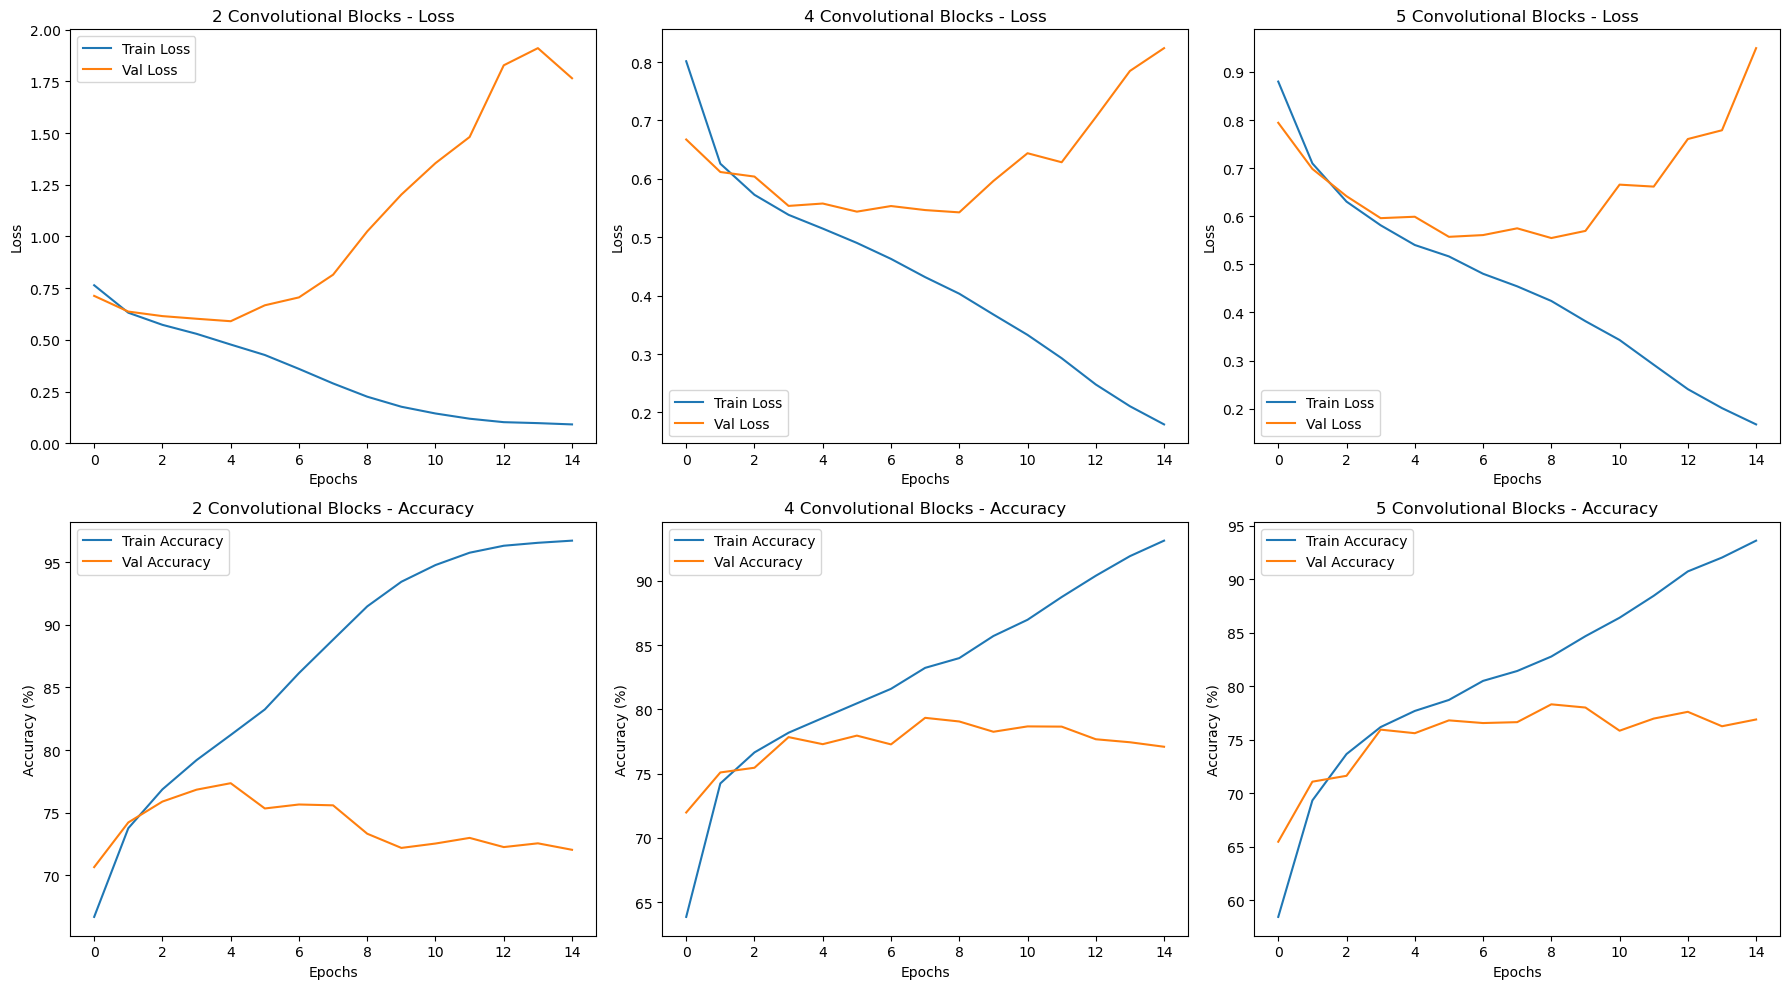

In [21]:
import matplotlib.pyplot as plt

def plot_performance(results):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 2 rows, 3 columns for each depth
    depth_values = [2, 4, 5]  # Assuming you trained models with 2, 3, and 4 blocks
    
    for idx, depth in enumerate(depth_values):
        # Get the results for the current depth
        train_losses, val_losses, train_acc, val_acc = results[depth]
        
        # Plot training vs validation loss (Row 1, Column for each depth)
        axes[0, idx].plot(train_losses, label='Train Loss')
        axes[0, idx].plot(val_losses, label='Val Loss')
        axes[0, idx].set_title(f'{depth} Convolutional Blocks - Loss')
        axes[0, idx].set_xlabel('Epochs')
        axes[0, idx].set_ylabel('Loss')
        axes[0, idx].legend()

        # Plot training vs validation accuracy (Row 2, Column for each depth)
        axes[1, idx].plot(train_acc, label='Train Accuracy')
        axes[1, idx].plot(val_acc, label='Val Accuracy')
        axes[1, idx].set_title(f'{depth} Convolutional Blocks - Accuracy')
        axes[1, idx].set_xlabel('Epochs')
        axes[1, idx].set_ylabel('Accuracy (%)')
        axes[1, idx].legend()
    
    # Adjust the layout to prevent overlap
    plt.tight_layout()
    plt.show()

# Call the plotting function to visualize the results
plot_performance(results)


In [ ]:
#

### Observations on Varying the number of convolution blocks

- All three models experience overfitting around epoch 6, as seen by the increasing validation loss and decreasing training loss. The model with **4 convolutional blocks** offers the best balance between learning and generalization, as its validation loss shows less fluctuation compared to the 2-block and 5-block configurations.
  
- The **2-block model** shows the most severe overfitting, with a sharp increase in validation loss after epoch 6, while the **5-block model** does not show significant improvements in validation performance over the 4-block model, despite having more complexity.

#### Best Model:
- The model with **4 convolutional blocks** performs the best in terms of generalization and stability across epochs. It demonstrates lower validation loss fluctuation compared to the other configurations, making it the most reliable model amongst the 3 models.


In [ ]:
#

## Approach 4  Optimization Strategy 

### An optimization strategy from Approach 4.  How did I do it?  What worked?


In [ ]:
#

For the optimization strategy, I experimented with:

1. **Data Augmentation**: I added more data augmentation techniques, like **random rotations** and **brightness adjustments**, to help improve generalization and prevent overfitting, which I observed in earlier experiments. The idea is to expose the model to more varied data, making it better at handling unseen images by learning more robust features.


2. **Weight Decay and Momentum**: I applied **weight decay** (L2 regularization) to penalize large weights, reducing the risk of overfitting. In addition, I used **momentum** to help accelerate the learning process and stabilize the updates, ensuring that the model converges faster while avoiding oscillations.


3. **Regularization**: I integrated **Dropout** layers across both the convolutional and fully connected layers. Dropout helps by randomly dropping neurons during training, forcing the network to learn more generalized representations rather than memorizing the training data. To further stabilize training, I added **Batch Normalization** after every convolutional layer, which normalizes the activations and speeds up convergence.


4. **Class Imbalance Handling**: Since there was an imbalance between the classes—'portrait' had significantly more samples than 'abstract' and 'landscape'—I addressed this by using **weighted cross-entropy loss**. This method assigns higher weights to the minority classes ('abstract' and 'landscape') to ensure that the model doesn't bias its predictions toward the majority class. This approach helped the model treat all classes more equally during training and improved performance, especially for the minority classes.


These changes helped stabilize the training, and while the model still showed signs of overfitting, the combination of data augmentation, regularization, and weight decay improved the generalization performance significantly as shown by the results of the optimized CNN below.


### Approach 5 Optimized CNN classifier 

### Further optimizing the classifier to achieve the best results possible.   Create a plot of the training and validation results as a function of the epoch.  

In [45]:
from torchvision import transforms

# Data augmentation with rotation and brightness change
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=15),  # Randomly rotate the image by ±15 degrees
    transforms.ColorJitter(brightness=0.3),  # Random brightness change
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation transform (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# apply the appropriate transforms
train_dataset = ImageDataset(train_data, transform=train_transform)
val_dataset = ImageDataset(val_data, transform=val_transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)


In [131]:
import torch.nn as nn
# debugged by chatGPT
class BaselineCNNWithBatchNormAndDropout(nn.Module):
    
    def __init__(self, num_classes=3): 
        super(BaselineCNNWithBatchNormAndDropout, self).__init__()
        
        # First convolutional block
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization added
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(32)  # Batch normalization added
        self.maxPool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.3)  # Dropout added to first block
        
        # Second convolutional block
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(64)  # Batch normalization added
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(64)  # Batch normalization added
        self.maxPool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.3)  # Dropout added to second block
        
        # Third convolutional block
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.bn5 = nn.BatchNorm2d(128)  # Batch normalization added
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3)
        self.bn6 = nn.BatchNorm2d(128)  # Batch normalization added
        self.maxPool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(0.3)  # Dropout added to third block
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 24 * 24, 256)
        self.dropout_fc = nn.Dropout(0.5)  # Dropout before fully connected layers
        self.fc2 = nn.Linear(256, num_classes)
        
        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # First conv block
        x = self.bn1(self.relu(self.conv1(x)))  # BatchNorm after ReLU
        x = self.bn2(self.relu(self.conv2(x)))
        x = self.maxPool1(x)
        x = self.dropout1(x)  # Apply dropout
        
        # Second conv block
        x = self.bn3(self.relu(self.conv3(x)))
        x = self.bn4(self.relu(self.conv4(x)))
        x = self.maxPool2(x)
        x = self.dropout2(x)  # Apply dropout
        
        # Third conv block
        x = self.bn5(self.relu(self.conv5(x)))
        x = self.bn6(self.relu(self.conv6(x)))
        x = self.maxPool3(x)
        x = self.dropout3(x)  # Apply dropout
        
        # Flatten the output from the conv layers
        x = x.view(x.size(0), -1)  # Flatten the tensor
        
        # Fully connected layers
        x = self.relu(self.fc1(x))
        x = self.dropout_fc(x)  # Apply dropout before the final layer
        x = self.fc2(x)
        
        return x

In [53]:
# Instantiate the updated model with BatchNorm and Dropout
model_finetune2 = BaselineCNNWithBatchNormAndDropout(num_classes=3).to(device)

# Optimizer with SGD, momentum, and weight decay
optimizer = torch.optim.SGD(model_finetune2.parameters(), lr=0.003, momentum=0.9, weight_decay=1e-4)

# Compute class weights based on the inverse of the class frequency
class_counts = [18371, 15005, 9498]  # Class frequencies for portrait, landscape, abstract
class_weights = [1 / count for count in class_counts]
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Use weighted cross-entropy loss
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Learning Rate Scheduler (ReduceLRonPlateau)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1, verbose=True)

# Training loop function remains the same, but we now include the scheduler
def train_cnn_with_scheduler(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()  # Zero out gradients
            
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss with class weights
            
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train

        # Append training loss and accuracy for plotting
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)  # Validation with weighted loss
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        val_loss /= len(val_loader)
        val_acc = 100 * correct_val / total_val
        
        # Append validation loss and accuracy for plotting
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        # Reduce the learning rate when the validation loss plateaus
        scheduler.step(val_loss)
        
        # Save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_cnn_model_bn_dropout.pth')

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, '
              f'Train Acc: {train_acc:.2f}%, '
              f'Val Loss: {val_loss:.4f}, '
              f'Val Acc: {val_acc:.2f}%')

    return train_losses, val_losses, train_accuracies, val_accuracies

# Example of how to call the training loop with the scheduler
train_losses, val_losses, train_accuracies, val_accuracies = train_cnn_with_scheduler(
    model_finetune2, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, device=device
)


Epoch [1/50], Train Loss: 0.7644, Train Acc: 63.21%, Val Loss: 0.7318, Val Acc: 69.68%
Epoch [2/50], Train Loss: 0.6560, Train Acc: 69.14%, Val Loss: 0.6987, Val Acc: 71.68%
Epoch [3/50], Train Loss: 0.6187, Train Acc: 71.31%, Val Loss: 0.5860, Val Acc: 72.85%
Epoch [4/50], Train Loss: 0.5889, Train Acc: 72.96%, Val Loss: 0.5663, Val Acc: 75.77%
Epoch [5/50], Train Loss: 0.5617, Train Acc: 74.27%, Val Loss: 0.5412, Val Acc: 75.02%
Epoch [6/50], Train Loss: 0.5512, Train Acc: 75.00%, Val Loss: 0.5196, Val Acc: 77.22%
Epoch [7/50], Train Loss: 0.5323, Train Acc: 75.82%, Val Loss: 0.5069, Val Acc: 78.08%
Epoch [8/50], Train Loss: 0.5123, Train Acc: 76.97%, Val Loss: 0.4920, Val Acc: 76.82%
Epoch [9/50], Train Loss: 0.4984, Train Acc: 77.62%, Val Loss: 0.5156, Val Acc: 77.67%
Epoch [10/50], Train Loss: 0.4880, Train Acc: 78.17%, Val Loss: 0.4749, Val Acc: 79.98%
Epoch [11/50], Train Loss: 0.4756, Train Acc: 78.76%, Val Loss: 0.5201, Val Acc: 77.48%
Epoch [12/50], Train Loss: 0.4697, Train 

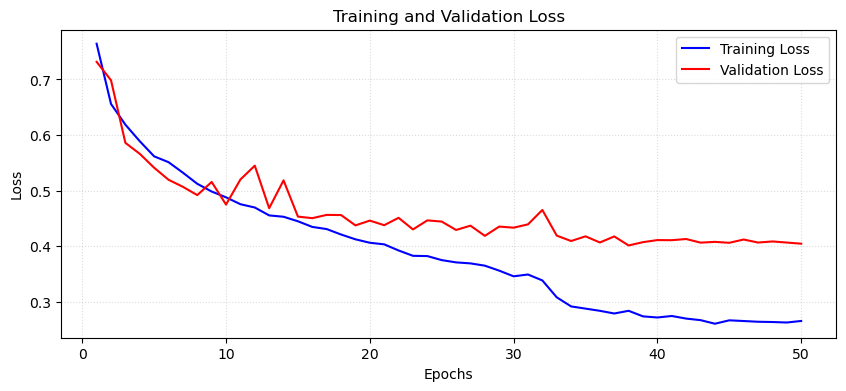

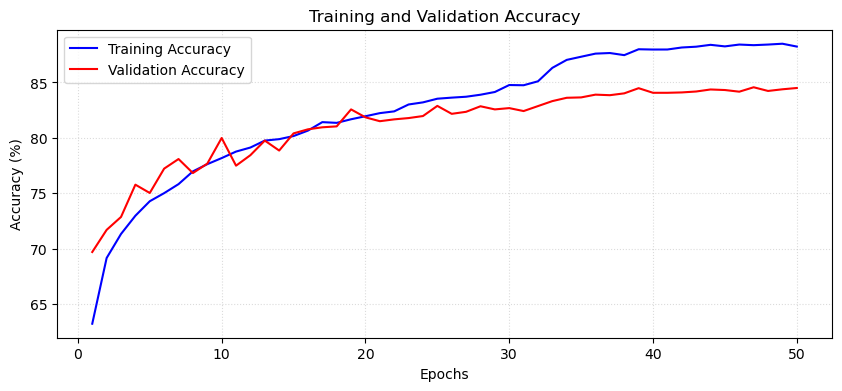

In [128]:
epochs = range(1, len(train_losses) + 1)
    
# Plot Loss
plt.figure(figsize=(10, 4))
plt.plot(epochs, train_losses, 'b', label='Training Loss')
plt.plot(epochs, val_losses, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(alpha=0.45, linestyle=':')
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.plot(epochs, train_accuracies, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.grid(alpha=0.45, linestyle=':')
plt.legend()
plt.show()
    

In [ ]:
#

## Final predictions 

### Outline

### Performing a classification on the test images with the optimized classifier.  This is the first time we should be using the test folder.  Compute the prediction accuracy through a confusion matrix (True Positive, True Negative, False Positive, False Negative) and overall accuracy which is the fraction of (True Positive + True Negative).  Display a few misclassified images from each class.

In [81]:
import warnings
warnings.filterwarnings("ignore")

# load saved model
model_final = BaselineCNNWithBatchNormAndDropout(num_classes=3)
model_final.load_state_dict(torch.load('best_cnn_model_bn_dropout.pth'))  # Load the saved model
model_final.eval()  # Set the model to evaluation mode

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using {device} device")

model_final.to(device)

# Test transform (same as val_transform, no augmentation)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Prepare the test data list from the DataFrame
test_data_list = []

for index, row in df.iterrows():
    image_path = os.path.join(data_folder, row['TrainValidateTest'], row['Filename'])
    if row['TrainValidateTest'] == 'test':
        test_data_list.append((image_path, row['Style']))  # Append image path and label (Style)

# Create test dataset and dataloader
test_dataset = ImageDataset(test_data_list, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)  # No need to shuffle test data

# Verify the dataset has been loaded correctly
print(f"Number of test samples: {len(test_dataset)}")


Using mps device
Number of test samples: 4882


In [82]:
import numpy as np
from sklearn.metrics import confusion_matrix
import torch

# Initialize lists to store the true labels and predicted labels
true_labels = []
predicted_labels = []

# inference
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
    
        # Forward pass
        outputs = model_final(images)
        _, preds = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())  # Collect true labels
        predicted_labels.extend(preds.cpu().numpy())  # Collect predicted labels

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)


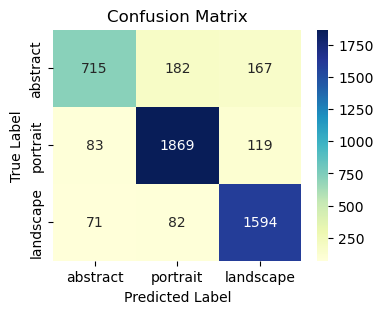

In [87]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Plot the confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=['abstract', 'portrait', 'landscape'], yticklabels=['abstract', 'portrait', 'landscape'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [107]:
# helper function to calculate accuracy by claude
def compute_accuracy(true_labels, predicted_labels):
    # Compute the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    
    # Get the number of classes
    num_classes = cm.shape[0]
    
    # Initialize variables to store TP, TN, FP, FN for each class
    tp = np.zeros(num_classes)
    tn = np.zeros(num_classes)
    fp = np.zeros(num_classes)
    fn = np.zeros(num_classes)
    
    # Compute TP, TN, FP, FN for each class
    for i in range(num_classes):
        tp[i] = cm[i, i]
        fn[i] = np.sum(cm[i, :]) - cm[i, i]
        fp[i] = np.sum(cm[:, i]) - cm[i, i]
        tn[i] = np.sum(cm) - (tp[i] + fn[i] + fp[i])
    
    # Compute overall accuracy
    overall_accuracy = np.sum(tp) / np.sum(cm)
    
    # Compute class-wise accuracy
    class_accuracy = tp / (tp + fn)
    
    return {
        'confusion_matrix': cm,
        'true_positive': tp,
        'true_negative': tn,
        'false_positive': fp,
        'false_negative': fn,
        'overall_accuracy': overall_accuracy,
        'class_accuracy': class_accuracy
    }


results = compute_accuracy(true_labels, predicted_labels)

print(f"\nOverall Accuracy: {results['overall_accuracy']*100:.2f}%")
print(f"\nClass-wise Accuracy:\n\
        Abstract: {results['class_accuracy'][0]*100:.2f}%\n\
        Portrait: {results['class_accuracy'][1]*100:.2f}%\n\
        Landscape: {results['class_accuracy'][2]*100:.2f}%")


Overall Accuracy: 85.58%

Class-wise Accuracy:
        Abstract: 67.20%
        Portrait: 90.25%
        Landscape: 91.24%


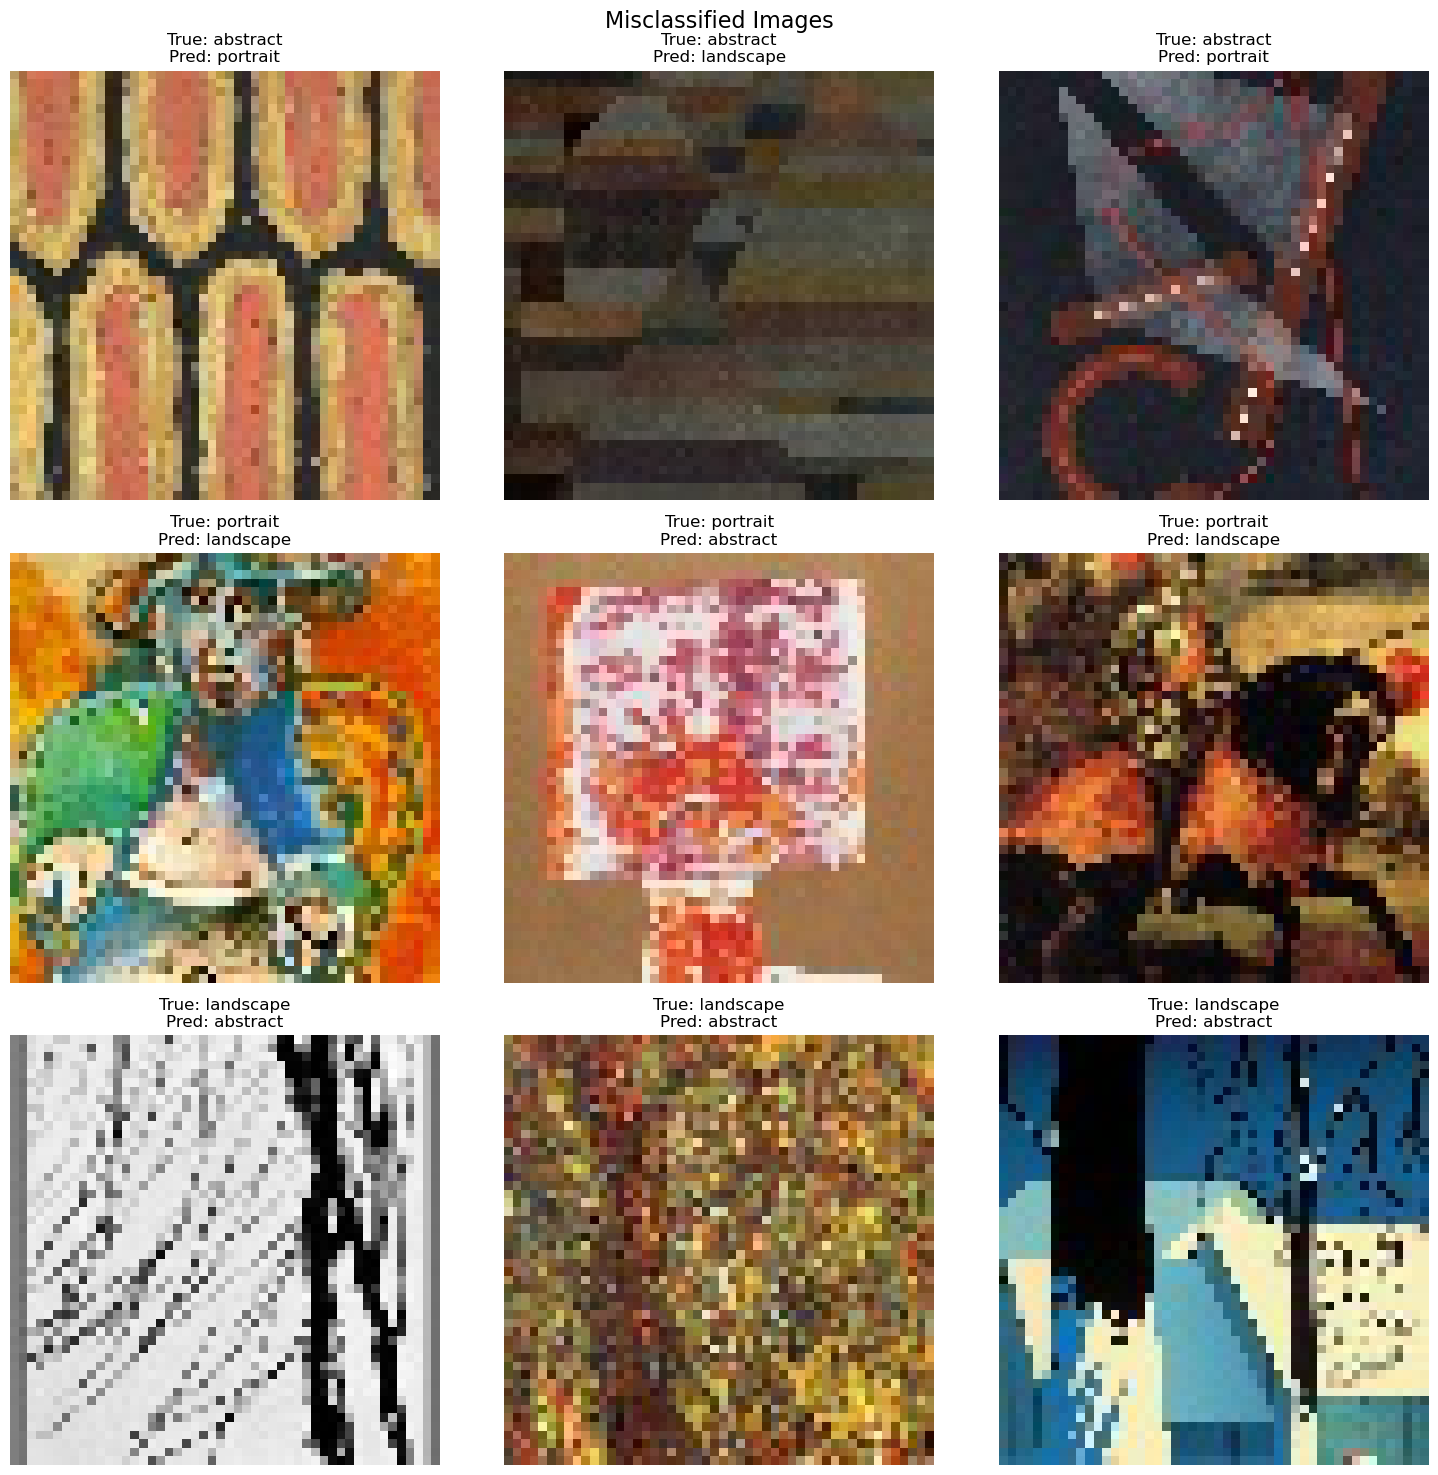

In [109]:

from PIL import Image
from torchvision import transforms

# helper function by claude
def display_misclassified_images(model, test_dataset, device, num_images=3):
    
    model.eval()  # Set the model to evaluation mode
    
    # Create a reverse mapping from index to label
    idx_to_label = {0: 'abstract', 1: 'portrait', 2: 'landscape'}
    
    misclassified = {label: [] for label in idx_to_label.values()}
    
    # Collect misclassified images
    for idx in range(len(test_dataset)):
        image, true_label = test_dataset[idx]
        image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
        
        with torch.no_grad():
            output = model(image)
            _, predicted_label = torch.max(output, 1)
        
        predicted_label = predicted_label.item()
        
        if predicted_label != true_label:
            true_label_str = idx_to_label[true_label]
            pred_label_str = idx_to_label[predicted_label]
            
            # Get the original image path
            img_path, _ = test_dataset.data[idx]
            
            misclassified[true_label_str].append((img_path, true_label_str, pred_label_str))
    
    # Plot misclassified images
    fig, axes = plt.subplots(3, num_images, figsize=(15, 15))
    fig.suptitle("Misclassified Images", fontsize=16)
    
    for i, label in enumerate(idx_to_label.values()):
        misclassified_for_label = misclassified[label][:num_images]
        
        for j in range(num_images):
            ax = axes[i, j]
            if j < len(misclassified_for_label):
                img_path, true_label, pred_label = misclassified_for_label[j]
                # Load and display the image
                img = Image.open(img_path).convert('RGB')
                ax.imshow(img)
                ax.set_title(f"True: {true_label}\nPred: {pred_label}")
            ax.axis('off')
        
        axes[i, 0].set_ylabel(label, fontsize=12, rotation=90, labelpad=20)
    
    plt.tight_layout()
    plt.show()


display_misclassified_images(model_final, test_dataset, device)

## Final Notes

### What characteristics of the CNN (beyond optimizing the hyperparameters) contributed to the presumably better performance than the feedforward network approach?

The CNN approach likely performed better than the feed forward approach because of the following characteristics: 

1. CNNS use convolutional layers that apply filters to small regions of the image, allowing them to capture spatial relationships like edges and textures. The convolutional layers act as feature extractors, automatically learning to detect important visual elements without human supervision.(helpful for distinguishing between 'portrait,' 'landscape,' and 'abstract' classes). Feedforward networks treat each input (pixel) independently, which means they can't directly capture these spatial patterns. This limitation makes them less effective for complex image analysis tasks. 


2. CNNs use the same set of filters (weights) across different parts of the image (parameter sharing). This reduces the total number of parameters in the network compared to a fully connected network of similar depth. This sharing of filters helps CNNs generalize better and recognize features regardless of their position in the image, which is  something that traditional feedforward networks struggle with.



3. CNNs have progressive feature learning, where initial layers detect basic features like edges, and deeper layers combine these to form more complex patterns. This progressive feature learning is very effective for image classification. Traditional feedforward networks lack this inherent capability, limiting their effectiveness in complex visual tasks. 



4. Max pooling layers in CNNs help reduces the dimensionality of feature maps while preserving salient information. This mechanism enhances the network's robustness to minor translations or distortions in input images. Feedforward networks lacking this mechanism are more susceptible to variations in input data, making them less robust for image classification tasks

